# Titanic - Machine Learning from Disaster

Легендарное ML-соревнование с [Kaggle](https://www.kaggle.com/c/titanic)

<img src='./Titanic.jpg' width=500>

Возможно, гибель Титаника - одно из самых печально известных кораблекрушений в истории. Титаник был крупнейшим действующим океанским лайнером своего времени, у него были улучшенные меры обеспечения безопасности, такие как водонепроницаемые отсеки и водонепроницаемые двери с дистанционным управлением. Корабль считался «непотопляемым», однако он затонул рано утром 15 апреля 1912 года в северной части Атлантического океана во время своего первого рейса из Саутгемптона в Нью-Йорк. В момент столкновения корабля с айсбергом на борту находились 2224 человека.

В соответствии с существующей в то время практикой система спасательных шлюпок Титаника была разработана для переправки пассажиров на ближайшие спасательные суда, а не для одновременного удержания всех на плаву. Таким образом, когда корабль быстро тонул (корабль затонул за 2 часа 40 минут), а до прибытия помощи оставалось еще несколько часов, многим пассажирам и членам экипажа не хватило места на спасательных шлюпках, которых было всего 20. Плохая организация эвакуации привела к тому, что многие лодки были спущены на воду до того, как были полностью заполнены.

В результате кораблекрушения погибло более 1500 человек, что сделало его одним из самых смертоносных в истории.

Без сомнения, при спасении пассажиров имел место элемент удачи, но, возможно, были те, кто имели большие шансы уцелеть чем другие. [Titanic ML competition on Kaggle](https://www.kaggle.com/c/titanic) предлагает участникам предсказать кто их пассажиров пережил кораблекрушение, основываясь на сохранившихся данных о пассажирах.

В Интернете можно найти десятки статей, посвященных этому соревнованию, и сотни решений этой задачи. В исследовательском анализе я во многом ориентировался на [эту статью](https://habr.com/ru/company/mlclass/blog/270973/) и позаимствовал из неё несколько идей.

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Импорт-необходимых-модулей" data-toc-modified-id="Импорт-необходимых-модулей-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Импорт необходимых модулей</a></span></li><li><span><a href="#Описание-проекта" data-toc-modified-id="Описание-проекта-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Описание проекта</a></span></li><li><span><a href="#Описание-данных" data-toc-modified-id="Описание-данных-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Описание данных</a></span></li><li><span><a href="#Примечания-к-признкакм" data-toc-modified-id="Примечания-к-признкакм-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Примечания к признкакм</a></span></li><li><span><a href="#Пути-к-файлам" data-toc-modified-id="Пути-к-файлам-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Пути к файлам</a></span></li><li><span><a href="#Предположения" data-toc-modified-id="Предположения-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Предположения</a></span></li><li><span><a href="#Анализ-таблицы-с-результатами-соревнований" data-toc-modified-id="Анализ-таблицы-с-результатами-соревнований-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Анализ таблицы с результатами соревнований</a></span></li><li><span><a href="#Загрузка-данных" data-toc-modified-id="Загрузка-данных-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Загрузка данных</a></span></li><li><span><a href="#Знакомство-с-данными" data-toc-modified-id="Знакомство-с-данными-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Знакомство с данными</a></span></li><li><span><a href="#Разделения-на-тестовый-и-тренировочный-наборы" data-toc-modified-id="Разделения-на-тестовый-и-тренировочный-наборы-10"><span class="toc-item-num">10&nbsp;&nbsp;</span>Разделения на тестовый и тренировочный наборы</a></span></li><li><span><a href="#Исследовательский-анализ" data-toc-modified-id="Исследовательский-анализ-11"><span class="toc-item-num">11&nbsp;&nbsp;</span>Исследовательский анализ</a></span><ul class="toc-item"><li><span><a href="#Предварительный-анализ" data-toc-modified-id="Предварительный-анализ-11.1"><span class="toc-item-num">11.1&nbsp;&nbsp;</span>Предварительный анализ</a></span></li><li><span><a href="#Детальный-анализ-признаков" data-toc-modified-id="Детальный-анализ-признаков-11.2"><span class="toc-item-num">11.2&nbsp;&nbsp;</span>Детальный анализ признаков</a></span><ul class="toc-item"><li><span><a href="#Pclass" data-toc-modified-id="Pclass-11.2.1"><span class="toc-item-num">11.2.1&nbsp;&nbsp;</span>Pclass</a></span></li><li><span><a href="#Name" data-toc-modified-id="Name-11.2.2"><span class="toc-item-num">11.2.2&nbsp;&nbsp;</span>Name</a></span></li><li><span><a href="#Sex" data-toc-modified-id="Sex-11.2.3"><span class="toc-item-num">11.2.3&nbsp;&nbsp;</span>Sex</a></span></li><li><span><a href="#Age" data-toc-modified-id="Age-11.2.4"><span class="toc-item-num">11.2.4&nbsp;&nbsp;</span>Age</a></span></li><li><span><a href="#SibSp" data-toc-modified-id="SibSp-11.2.5"><span class="toc-item-num">11.2.5&nbsp;&nbsp;</span>SibSp</a></span></li><li><span><a href="#Parch" data-toc-modified-id="Parch-11.2.6"><span class="toc-item-num">11.2.6&nbsp;&nbsp;</span>Parch</a></span></li><li><span><a href="#Fare" data-toc-modified-id="Fare-11.2.7"><span class="toc-item-num">11.2.7&nbsp;&nbsp;</span>Fare</a></span></li><li><span><a href="#Cabin" data-toc-modified-id="Cabin-11.2.8"><span class="toc-item-num">11.2.8&nbsp;&nbsp;</span>Cabin</a></span></li><li><span><a href="#Embarked" data-toc-modified-id="Embarked-11.2.9"><span class="toc-item-num">11.2.9&nbsp;&nbsp;</span>Embarked</a></span></li></ul></li><li><span><a href="#Correlation" data-toc-modified-id="Correlation-11.3"><span class="toc-item-num">11.3&nbsp;&nbsp;</span>Correlation</a></span></li></ul></li><li><span><a href="#Data-Preparation" data-toc-modified-id="Data-Preparation-12"><span class="toc-item-num">12&nbsp;&nbsp;</span>Data Preparation</a></span><ul class="toc-item"><li><span><a href="#Copy-a-clean-training-set" data-toc-modified-id="Copy-a-clean-training-set-12.1"><span class="toc-item-num">12.1&nbsp;&nbsp;</span>Copy a clean training set</a></span></li><li><span><a href="#Data-Cleaning" data-toc-modified-id="Data-Cleaning-12.2"><span class="toc-item-num">12.2&nbsp;&nbsp;</span>Data Cleaning</a></span></li><li><span><a href="#Feature-Selection" data-toc-modified-id="Feature-Selection-12.3"><span class="toc-item-num">12.3&nbsp;&nbsp;</span>Feature Selection</a></span></li><li><span><a href="#Feature-engineering" data-toc-modified-id="Feature-engineering-12.4"><span class="toc-item-num">12.4&nbsp;&nbsp;</span>Feature engineering</a></span></li><li><span><a href="#Discretization-of-continuous-variables" data-toc-modified-id="Discretization-of-continuous-variables-12.5"><span class="toc-item-num">12.5&nbsp;&nbsp;</span>Discretization of continuous variables</a></span></li><li><span><a href="#Handling-Categorical-Attributes" data-toc-modified-id="Handling-Categorical-Attributes-12.6"><span class="toc-item-num">12.6&nbsp;&nbsp;</span>Handling Categorical Attributes</a></span></li><li><span><a href="#Correlation" data-toc-modified-id="Correlation-12.7"><span class="toc-item-num">12.7&nbsp;&nbsp;</span>Correlation</a></span></li><li><span><a href="#Mutual-Info" data-toc-modified-id="Mutual-Info-12.8"><span class="toc-item-num">12.8&nbsp;&nbsp;</span>Mutual Info</a></span></li><li><span><a href="#" data-toc-modified-id="-12.9"><span class="toc-item-num">12.9&nbsp;&nbsp;</span></a></span></li></ul></li></ul></div>

## Импорт необходимых модулей

In [1]:
import matplotlib.pyplot as plt

import numpy as np

import pandas as pd
from pandas.plotting import scatter_matrix

import seaborn as sns

from scipy.stats import percentileofscore
from scipy.stats import ttest_ind

from sklearn.model_selection import train_test_split

# from sklearn.base import BaseEstimator
# from sklearn.base import TransformerMixin
# from sklearn.feature_selection import mutual_info_classif
# from sklearn.impute import SimpleImputer
# from sklearn.impute import MissingIndicator
# from sklearn.pipeline import Pipeline
# from sklearn.preprocessing import FunctionTransformer
# from sklearn.preprocessing import KBinsDiscretizer
# from sklearn.preprocessing import OneHotEncoder
# from sklearn.preprocessing import OrdinalEncoder

# from sklearn_pandas import DataFrameMapper

# 

%matplotlib inline

## Описание проекта

**Цель** - предсказать выживет пассажир Тинтаника в кораблекрушении или нет.

**Тип задачи** - классификация (бинарная классификация).

**Целевая метрика** - *accuracy* (точность).

**Желаемое значение целевой метрики:** Табилца с результатами соревнований содержит почти 14000 записей. 
Медианное значение точности 0.775, но менее 4% имеют резутат выше 0.8. 
Таким образом, **значение метрики accuracy больше или равное 0.8 будет отличным результатом**.

**Существующие решения:** имеется огромное количество решений опубликованных в интернете и [на форуме](https://www.kaggle.com/c/titanic/discussion)

## Описание данных
0. **PassengerId** - ID пассажира.
1. **Survived** - Выживший:
    - 0 = Нет, 
    - 1 = Да.
2. **Pclass** - Класс билета:
    - 1 = первый, 
    - 2 = второй, 
    - 3 = третий.
3. **Name** - Имя пассажира, например Braund, Mr. Owen Harris.
4. **Sex** - Пол:
    - male - мужчина,
    - female - женщина.
5. **Age** - Возраст в годах, например 38.0.
6. **SibSp** - Количество братьев и сестер или супругов на борту Титаника.
7. **Parch** - Количество родителей или детей на борту Титаника.
8. **Ticket** - Номер билета, например A/5 21171.
9. **Fare** - Стоимость билета, например 71.2833.
10. **Cabin** - Номер каюты, напрмер C85.
11. **Embarked** - Порт, где пассажир сел на корабль:
    - C = Cherbourg,
    - Q = Queenstown,
    - S = Southampton.
    
**Признаки:** PassengerId, Pclass, Name, Sex, Age, SibSp, Parch, Ticket,
Fare, Cabin, Embarked

**Целевой признак** - Survived
    
## Примечания к признкакм
- **pclass**: социально-экономический статус
    - *1st* = Upper
    - *2nd* = Middle
    - *3rd* = Lower
- **age**: Возраст представлен дробным значением, если он меньше 1 года. Если возрас известен, то значение имеет вид xx.5.
- **sibsp**: Количество братьев и сестер или супругов на борту Титаника
    - *sibling* = брат, сестра, сводный брат, сводная сестра
    - *spouse* = муж, жена (любовницы, женихи и невесты игнорировались)
- **parch**: количество родителей (мать, отец)/детей (дочь, сын, в т.ч. приёмные) на борту Титаника. Некоторые дети путешествовали только с няней, поэтому для них parch=0.

## Пути к файлам
- **training set**: ../datasets/train.csv - набор данных для обучения модели.
- **test set**: ../datasets/test.csv - набор для подготовки предсказания для отправки на проверку.
- **example of a submission file**: ../datasets/gender_submission.csv - пример данных, подготовленных для проверки. В нём значения целевой переменной расставлены случайным образом.

## Предположения
У женщин было больше шансов выжить, чем у мужчин.

## Анализ таблицы с результатами соревнований
Скачаем [таблицу с результатами соревнования](https://www.kaggle.com/competitions/titanic/leaderboard) и проанализируем результаты в ней. Таблица загружена 07.01.2023.

Выведем первые 5 строк таблицы.

In [2]:
leaderboard = pd.read_csv('../datasets/titanic-publicleaderboard.csv')
leaderboard.head()

,TeamId,TeamName,SubmissionDate,Score
0,6987444,no name,2022-11-29 19:21:00,1.0
1,9431126,GloriaWin,2022-11-09 03:47:31,1.0
2,9433446,Ouyang Hao,2022-11-09 12:25:50,1.0
3,7943932,Aleksei Fomin,2022-12-07 08:36:15,1.0
4,9157107,Chaceli,2022-11-13 11:47:50,1.0


Неожиданно, в начале таблицы оказались результаты с точностью (метрика accuracy) равной 1. Неужели авторы смогли достичь совершенства?

Посчитаем описательные статистики для результатов приведённых в таблице (столбец `Score`).

In [3]:
leaderboard.Score.describe()

count    13702.000000
mean         0.758821
std          0.083441
min          0.000000
25%          0.765550
50%          0.775110
75%          0.777510
max          1.000000
Name: Score, dtype: float64

Посчитаем процент участников показавших результат лучше 0.8.

In [4]:
print(f'Только {1 - percentileofscore(leaderboard.Score, 0.8) / 100 :.2%} участников показали результат лучше 0.8')

Только 3.74% участников показали результат лучше 0.8


Таким образом, **значение метрики accuracy больше или равное 0.8 будет отличным результатом**.

Построим функцию распределения (ECDF) вероятности результатов участников. Красным отметим желаемое значение целевой метрики.

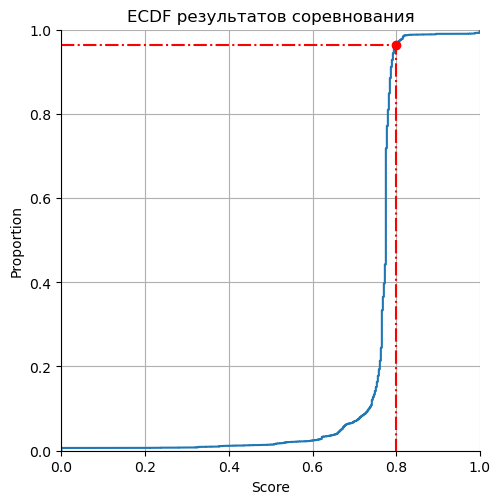

In [5]:
def plot_ecdf_with_target(data, target):
    sns.displot(data, stat='proportion', kind='ecdf', height=5, aspect=1)
    
    quantile = percentileofscore(data, target) / 100
    
    plt.plot([0, target, target], [quantile, quantile, 0], '-.r')
    plt.plot([target], [quantile], 'or')
    
    plt.xlim((0, 1))
    plt.ylim((0, 1))
    
    plt.title('ECDF результатов соревнования')
    
    plt.grid()
    
    plt.show()

    
plot_ecdf_with_target(leaderboard.Score, 0.8)

Построим плотность распределения вероятности получения определённого результата соревнования. Красной стрелкой отметим результаты равные 1.0 .

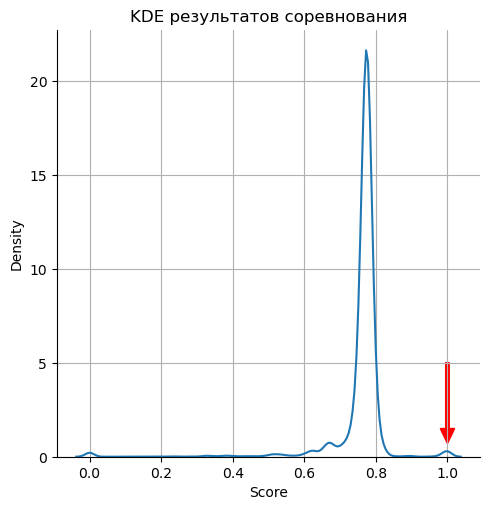

In [6]:
sns.displot(leaderboard, x='Score', kind='kde')

plt.arrow(x=1.0, y=5, dx=0, dy=-3.5, width=0.01, head_width=0.04, head_length=0.8, color='r')
plt.title("KDE результатов соревнования")
plt.grid()

plt.show()

Возможно, решения с "совершенным" результатом появились из-за того, что на [GitHub](https://github.com/thisisjasonjafari/my-datascientise-handcode/raw/master/005-datavisualization/titanic.csv) есть точное решение задачи соревнования. Вполен возможно, что выложены данные, извлечённые из [Encyclopedia Titanica](https://www.encyclopedia-titanica.org/titanic-survivors/) или из [OpenML](https://www.openml.org/search?type=data&sort=runs&id=40945&status=active).

Некоторые авторы в своих тетрадках честно предупреждают других пользователей о наличии такой возможности, например [вот этот](https://www.kaggle.com/code/suzukifelipe/how-to-be-a-top-lb-explained-for-beginners/notebook?scriptVersionId=99817039).

Приступим к решению задачи.

## Загрузка данных
Загрузим набор данных для разработки модели. Далее будем работать с этим набором данных.

In [7]:
data = pd.read_csv('../datasets/train.csv')

Загрузим набор признкаов для отправки результатов на проверку. Отложим этот набор.

In [8]:
submission_X = pd.read_csv('../datasets/test.csv')

## Знакомство с данными
Выведем форму датасета.

In [9]:
print(f'Датасет содержит {data.shape[0]} строку и {data.shape[1]} столбцов.')

Датасет содержит 891 строку и 12 столбцов.


Выведем на экран первые 10 строк датасета

In [10]:
data.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


Проверим типы данных признаков и наличие пропусков

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


Столбцы `Age`, `Cabin`, `Embarked` содержат пропуски, причём, в столбце `Cabin` пропусков большинство.

Проверим есть ли дисбаланс классов целевой переменной.

In [12]:
def check_target_imbalance(vals):
    mean_val = vals.mean()
    
    print(f'Доля выживших пассажиров - {mean_val: .2%}')
    print(f'Доля погибших пассажиров - {1 - mean_val: .2%}')
    
check_target_imbalance(data.Survived)

Доля выживших пассажиров -  38.38%
Доля погибших пассажиров -  61.62%


В датасете есть дисбаланс классов, поэтому будем использовать стратификацию при разделении на тренировочный и тестовый наборы и апсемплинг при обучении модели.

проверим наличие дубликатов в наборе данных.

In [13]:
if data.duplicated().any():
    print('В данных есть дубликаты!')
else:
    print('Дубликаты не обнаружены.')

Дубликаты не обнаружены.


## Разделения на тестовый и тренировочный наборы
Чтобы обучить модель и спрогнозировать точность её предсказаний на новых данных (результат соревнования) необходимо разделить данные (датафрейм `data`) на тестовый и тренировочный наборы. При разделении будем делать стратификацию по целевому признаку.

In [14]:
X = data.drop(columns = 'Survived')
y = data.Survived.copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

Проверим дисбаланс классов в тренировочной выборке

In [15]:
check_target_imbalance(y_train)

Доля выживших пассажиров -  38.34%
Доля погибших пассажиров -  61.66%


Проверим дисбаланс классов в тестовой выборке

In [16]:
check_target_imbalance(y_test)

Доля выживших пассажиров -  38.55%
Доля погибших пассажиров -  61.45%


Пропорции приблизительно одинаковые.

## Исследовательский анализ

### Предварительный анализ

Распечатаем описательные статистики для числовых признаков

In [17]:
X_train.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,712.000000,712.000000,575.000000,712.000000,712.000000,712.000000
mean,444.405899,2.308989,29.807687,0.492978,0.390449,31.819826
std,257.465527,0.833563,14.485211,1.060720,0.838134,48.059104
min,1.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,222.750000,2.000000,21.000000,0.000000,0.000000,7.895800
50%,439.500000,3.000000,28.500000,0.000000,0.000000,14.454200
75%,667.250000,3.000000,39.000000,1.000000,0.000000,31.000000
max,891.000000,3.000000,80.000000,8.000000,6.000000,512.329200


В таблицу попал категориальный признак `Pclass` рассмотрим его отдельно

In [18]:
X_train[['Pclass']].astype('object').describe()

,Pclass
count,712
unique,3
top,3
freq,391


Выведем описательные статистики для столбцов с типом `object`.

In [19]:
X_train.describe(include='object')

,Name,Sex,Ticket,Cabin,Embarked
count,712,712,712,160,710
unique,712,2,571,127,3
top,"Lam, Mr. Ali",male,1601,G6,S
freq,1,459,6,4,516


Признак `PassengerID` - уникальный идентификатор пассажира, он не несёт никакой информации. 

Признаки `Name` и `Ticket` имеют слишком большое количество уникальных значений и, скорее всего, не помогут нам. Однако, из признака `Name` можно извлечь титул, который принадлежал человеку, нёс информацию о его социально-экономическом положении и, чисто теоретически, мог влиять на шанс выжить.

Признак `Cabin` содержит большое количество пропущенных значений, тем не менее, можно попробовать предположить, что номер каюты известен для выживших пассажиров, и закодировать номер каюты единицей, когда он известен, а когда не известен, закодировать его нулём, или применить другой способ кодирования категориальной переменной.

Выведем гистограммы потенциально полезных количественных признаков.

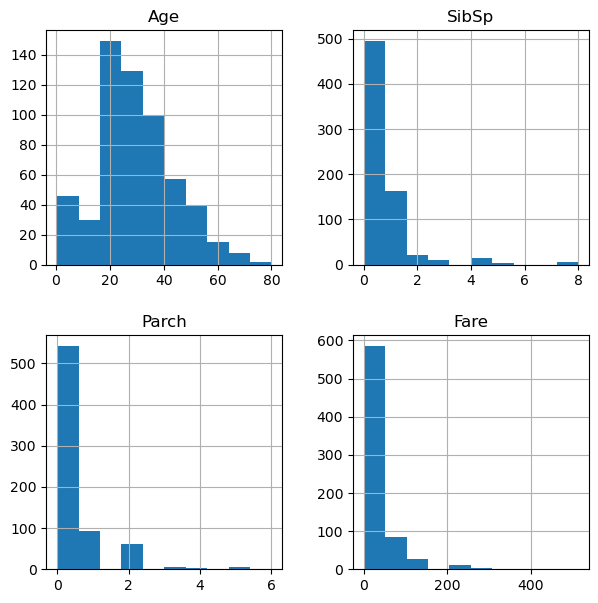

In [20]:
num_columns = ['Age', 'SibSp', 'Parch', 'Fare']

X_train[num_columns].hist(figsize=(7,7))
plt.show()

Распределение пассажиров по возрастам  близко к нормальному, остальные по форме далеки от нормального распределения. Также признаки имеют очень разные масштабы.

Проверим наличие корреляции между количественными признакми.

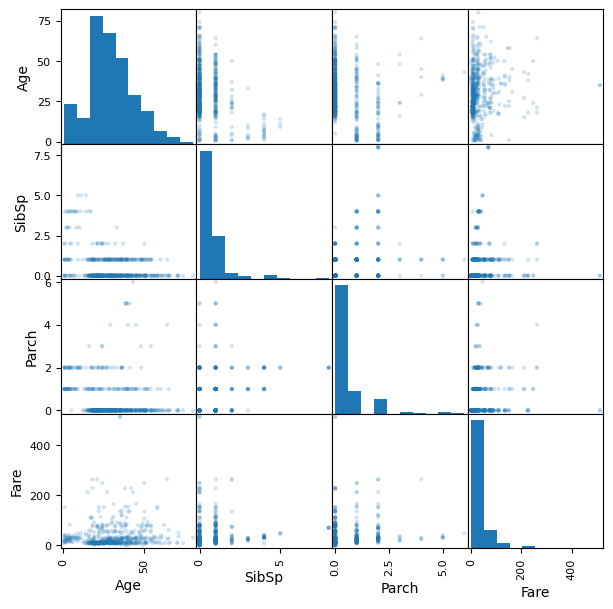

In [21]:
scatter_matrix(X_train[num_columns],
               figsize=(7, 7),
               alpha=0.2,
              )

plt.show()

Построим матрицу корреляции

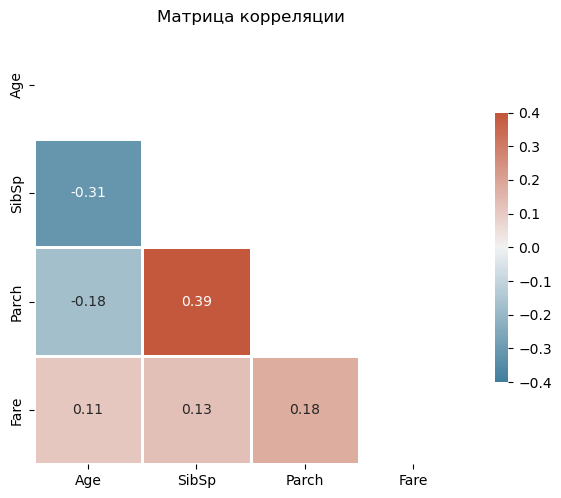

In [22]:
def plot_corr_matrix(df, size=(7, 7)):
    corr = df.corr()
    
    mask = np.triu(np.ones_like(corr, dtype=bool))
    
    f, ax = plt.subplots(figsize=size)
    
    cmap = sns.diverging_palette(230, 20, as_cmap=True)
    
    sns.heatmap(corr,
                mask=mask,
                cmap=cmap,
                annot=True,
                vmax=0.4,
                vmin=-0.4,
                center=0.0,
                square=True,
                linewidths=1.0,
                cbar_kws={'shrink': 0.5},
                ax=ax
               )
    
    ax.set_title('Матрица корреляции')
    
    plt.show()
    
plot_corr_matrix(X_train[num_columns])

Наблиюдается небольшая отрицательная корреляция между признакми `SibSp` и `Age`, коэффициент корреляции равер -0.31, и небольшая положительная корреляция между `Parch` и `SibSp`, коэффициент корреляции равен 0.39.

### Детальный анализ признаков
Рассмотрим каждый признак по отдельности, чтобы найти перспективные преобразования для них и выявить аномалии в данных. Признаки `PassengerId` и `Ticket` рассматривать не будем.

Для этого снова присоединим к набору целевой признак и присвоем их переменной `exploratory_set`.

In [23]:
exploratory_set = pd.concat([X_train, y_train], axis='columns')
exploratory_set.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived
692,693,3,"Lam, Mr. Ali",male,NaN,0,0,1601,56.4958,NaN,S,1
481,482,2,"Frost, Mr. Anthony Wood ""Archie""",male,NaN,0,0,239854,0.0000,NaN,S,0
527,528,1,"Farthing, Mr. John",male,NaN,0,0,PC 17483,221.7792,C95,S,0
855,856,3,"Aks, Mrs. Sam (Leah Rosen)",female,18.0,0,1,392091,9.3500,NaN,S,1
801,802,2,"Collyer, Mrs. Harvey (Charlotte Annie Tate)",female,31.0,1,1,C.A. 31921,26.2500,NaN,S,1


#### Pclass
Посчитаем количество пассажиров для каждого класса билета.

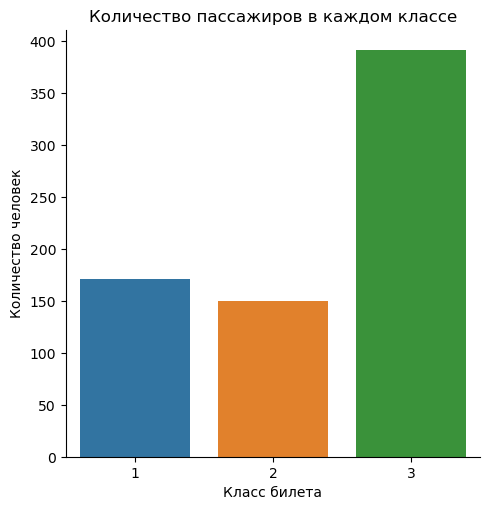

3    391
1    171
2    150
Name: Pclass, dtype: int64

In [24]:
sns.catplot(data=exploratory_set, x='Pclass', kind='count')

plt.title('Количество пассажиров в каждом классе')
plt.xlabel('Класс билета')
plt.ylabel('Количество человек')

plt.show()

display(exploratory_set.Pclass.value_counts())

Больше всего пассажиров находились в третьем классе.

Оценим долю выживших для каждого класса.

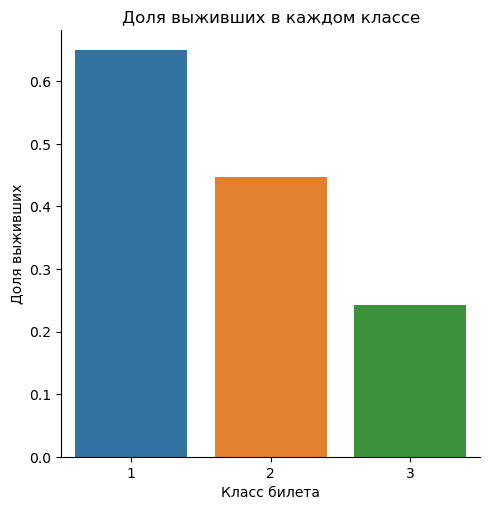

In [25]:
sns.catplot(data=exploratory_set, x='Pclass', y='Survived', kind='bar', errorbar=None)

plt.title('Доля выживших в каждом классе')
plt.xlabel('Класс билета')
plt.ylabel('Доля выживших')

plt.show()

Самая высока смертность была среди пассажиров третьего класса, возможно, это было связано с тем, что их каюты находились дальше всего от спасательных шлюпок.

Оценим долю выживших для каждого класса в разрезе полов.

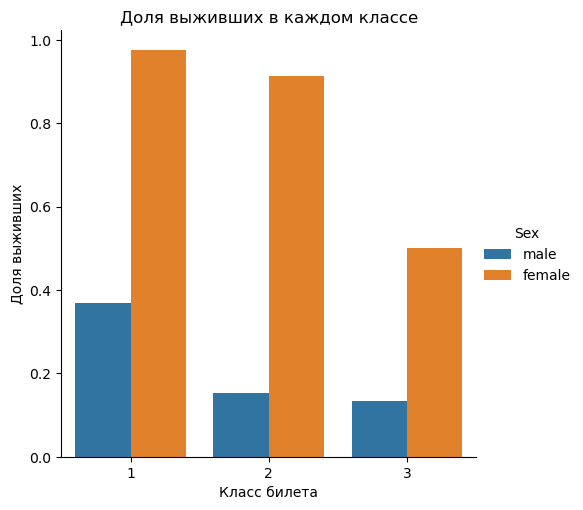

In [26]:
sns.catplot(data=exploratory_set, x='Pclass', y='Survived', hue='Sex', kind='bar', errorbar=None)

plt.title('Доля выживших в каждом классе')
plt.xlabel('Класс билета')
plt.ylabel('Доля выживших')

plt.show()

Таким образом, в каждом классе выжило больше женщин, чем мужчин. Самая высокая смертность была среди мужчин третьего класса.

#### Name
Имена пассажиров, как мы заметили в предварительном анализе, все уникальны. Однако, они содержат титул, который может указывать на социально-экономический статус пассажира и может быть связан с шансами выжить в кораблекружении.

Выведем первые 5 значений признака `Name`.

In [27]:
exploratory_set[['Name']].head()

,Name
692,"Lam, Mr. Ali"
481,"Frost, Mr. Anthony Wood ""Archie"""
527,"Farthing, Mr. John"
855,"Aks, Mrs. Sam (Leah Rosen)"
801,"Collyer, Mrs. Harvey (Charlotte Annie Tate)"


Выделим новый признак `Title` (титул) и добиви его к `exploratory_set`, затем выведем первые 5 строк получившегося датафрейма.

In [28]:
exploratory_set['Title'] = exploratory_set.Name.str.extract(pat=r'\b,\s(.+?)\.\s[\b(]?', expand=True)
exploratory_set['Title'] = exploratory_set['Title'].str.lower()
exploratory_set.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived,Title
692,693,3,"Lam, Mr. Ali",male,NaN,0,0,1601,56.4958,NaN,S,1,mr
481,482,2,"Frost, Mr. Anthony Wood ""Archie""",male,NaN,0,0,239854,0.0000,NaN,S,0,mr
527,528,1,"Farthing, Mr. John",male,NaN,0,0,PC 17483,221.7792,C95,S,0,mr
855,856,3,"Aks, Mrs. Sam (Leah Rosen)",female,18.0,0,1,392091,9.3500,NaN,S,1,mrs
801,802,2,"Collyer, Mrs. Harvey (Charlotte Annie Tate)",female,31.0,1,1,C.A. 31921,26.2500,NaN,S,1,mrs


Посчитаем описательные статистики для нового признака.

In [29]:
exploratory_set[['Title']].describe()

,Title
count,712
unique,14
top,mr
freq,412


Определим количество повторений каждого титула в наборе данных.

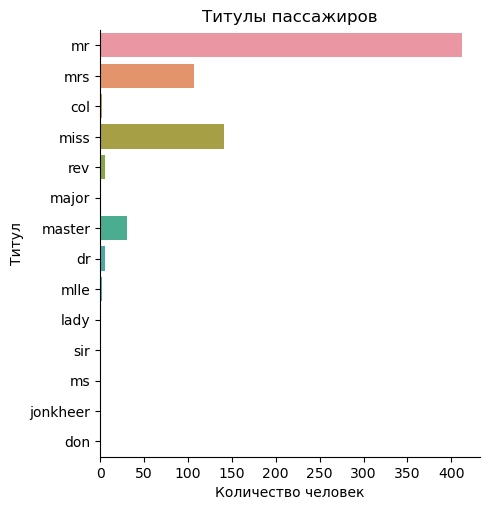

mr          412
miss        141
mrs         107
master       31
dr            6
rev           5
col           2
mlle          2
major         1
lady          1
sir           1
ms            1
jonkheer      1
don           1
Name: Title, dtype: int64

In [30]:
sns.catplot(data=exploratory_set, y='Title', kind='count')

plt.title('Титулы пассажиров')
plt.xlabel('Количество человек')
plt.ylabel('Титул')

plt.show()

display(exploratory_set.Title.value_counts(dropna=False))

Обращение *master* в то время использовалось по отношению к младенцам мужского пола. Также признак содержит несколько редко встречающихся титулов. Выведем их, затем вынесем в отдельный список `aristocratic_titles`.

In [31]:
aristocratic_titles = pd.DataFrame(exploratory_set.Title.value_counts()).query('Title < 10')
display(aristocratic_titles)

aristocratic_titles = list(aristocratic_titles.index)

,Title
dr,6
rev,5
col,2
mlle,2
major,1
lady,1
sir,1
ms,1
jonkheer,1
don,1


Заменим их значением *aristocratic* (аристократический).

In [32]:
exploratory_set.loc[exploratory_set.Title.isin(aristocratic_titles), 'Title'] = 'aristocratic'

Посмотрим как владельцы разных титулов были распределены по классам билетов.

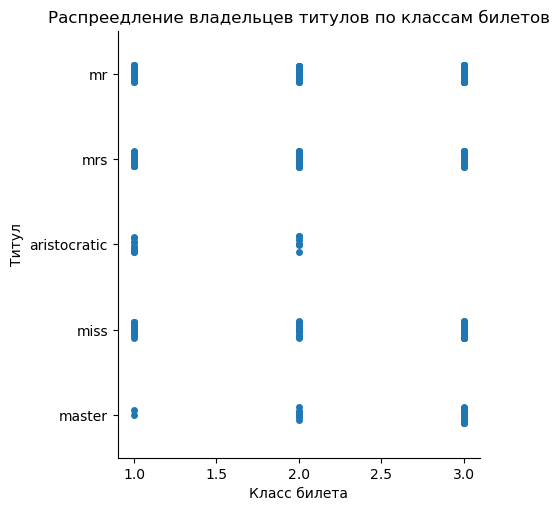

In [33]:
sns.catplot(data=exploratory_set, y='Title', x='Pclass', orient='h')

plt.title('Распреедление владельцев титулов по классам билетов')
plt.xlabel('Класс билета')
plt.ylabel('Титул')

plt.show()

Владельцы аристократических титулов занимали только первый и второй класс.

Оценим долю выживших для каждого титула.

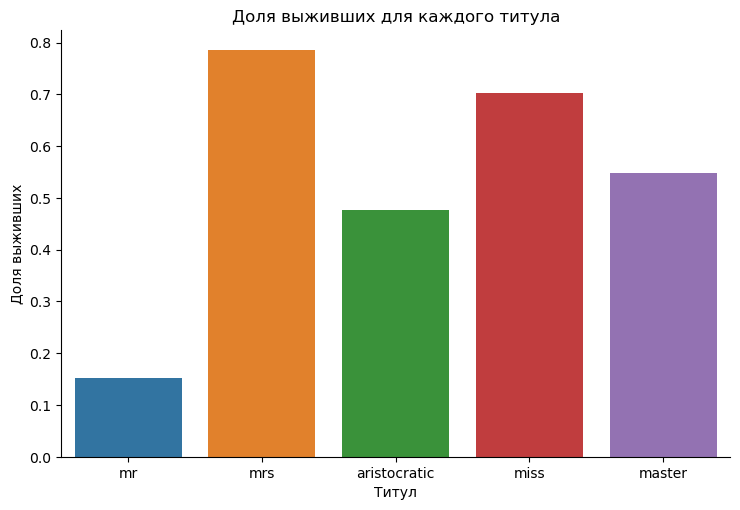

In [34]:
sns.catplot(data=exploratory_set, x='Title', y='Survived', kind='bar', errorbar=None, aspect=1.5)

plt.title('Доля выживших для каждого титула')
plt.xlabel('Титул')
plt.ylabel('Доля выживших')

plt.show()

По смотрим ту же метрику в разрезе полов.

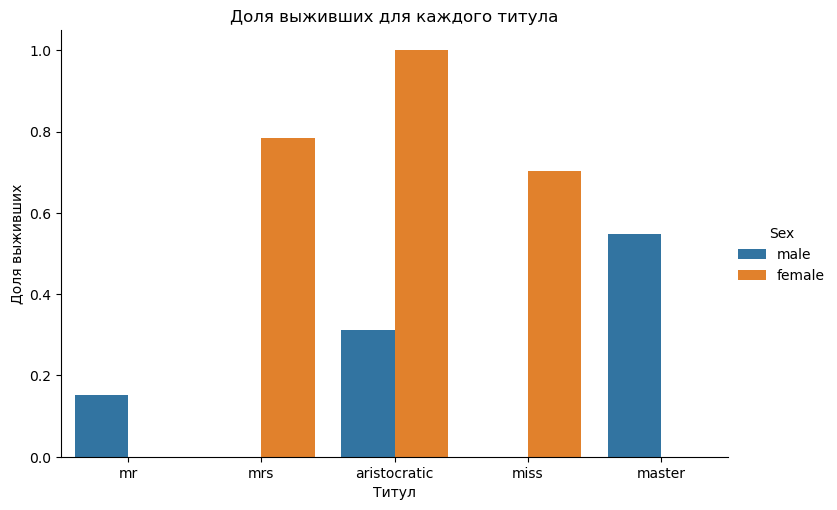

In [35]:
sns.catplot(data=exploratory_set, x='Title', y='Survived', hue='Sex', kind='bar', errorbar=None, aspect=1.5)

plt.title('Доля выживших для каждого титула')
plt.xlabel('Титул')
plt.ylabel('Доля выживших')

plt.show()

Среди мужчин на Титанике аристократы и младенцы имели более высокие шансы спастись.

#### Sex
Оценим количество женщин и мужчин севших на Титаник

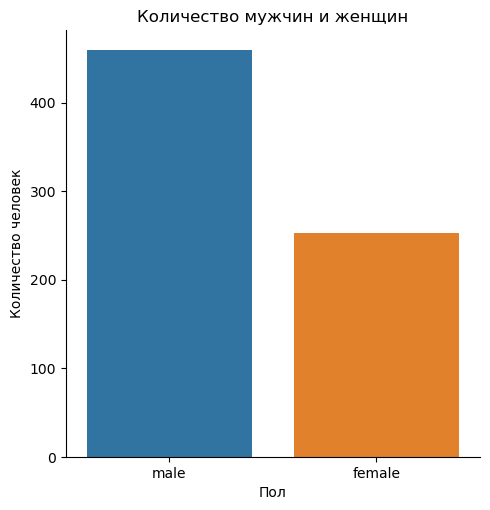

male      459
female    253
Name: Sex, dtype: int64

In [36]:
sns.catplot(data=exploratory_set, x='Sex', kind='count')

plt.title('Количество мужчин и женщин')
plt.xlabel('Пол')
plt.ylabel('Количество человек')

plt.show()

display(X_train.Sex.value_counts())

Мужчин на титанике было почти в 2 раза больше чем женщин.

Оценим количество выживших пассажиров каждого пола.

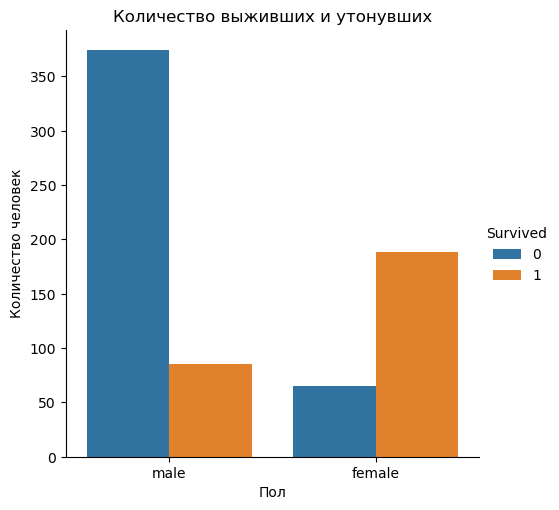

In [37]:
sns.catplot(data=exploratory_set, x='Sex', hue='Survived', kind='count')

plt.title('Количество выживших и утонувших')
plt.xlabel('Пол')
plt.ylabel('Количество человек')

plt.show()

Оценим долю выживших среди мужчин и женщин

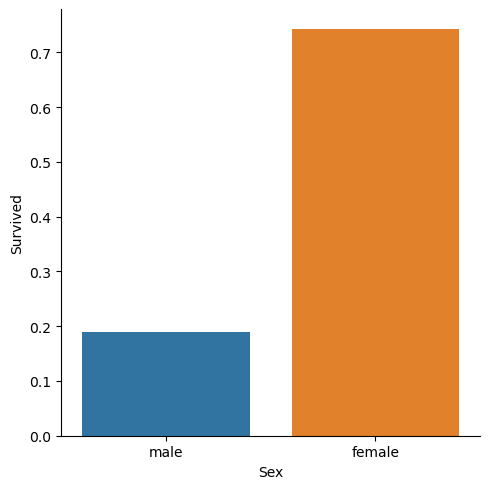

In [38]:
sns.catplot(data=data, x='Sex', y='Survived', kind='bar', errorbar=None)
plt.show()

Женщины на Титанике явно имели более высоки шансы выжить, чем мужчины, что согласуется с протоколом "Женщины и дети первые", действовавшим в то время.

#### Age

Рассмотрим распределение возрастов пассажиров Титаника, для этого построим гистограмму признака `Age`.

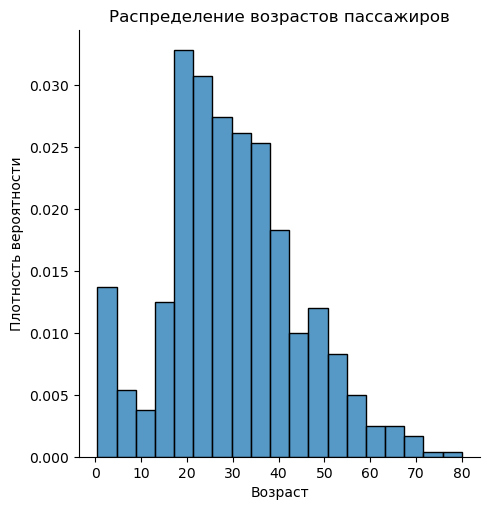

count    575.000000
mean      29.807687
std       14.485211
min        0.420000
25%       21.000000
50%       28.500000
75%       39.000000
max       80.000000
Name: Age, dtype: float64

In [39]:
sns.displot(exploratory_set.Age, stat='density')

plt.xlabel('Возраст')
plt.ylabel('Плотность вероятности')
plt.title('Распределение возрастов пассажиров')

plt.show()

display(exploratory_set.Age.describe())

Форма распределения отклоняется от формы нормального.

Проверим гипотезу о том, что выжившие пассажиры моложе погибших. Построим распределение возрастов отдельно для погибших и отдельно для выживших.

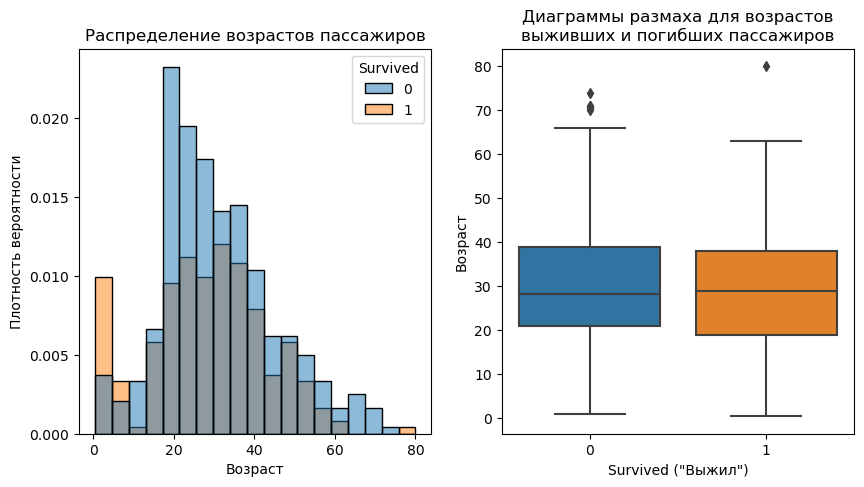

In [40]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))


sns.histplot(data=exploratory_set, x='Age', stat='density', hue='Survived', ax=ax[0])

ax[0].set_xlabel('Возраст')
ax[0].set_ylabel('Плотность вероятности')
ax[0].set_title('Распределение возрастов пассажиров')

sns.boxplot(data=exploratory_set, x='Survived', y='Age', ax=ax[1])

ax[1].set_xlabel('Survived ("Выжил")')
ax[1].set_ylabel('Возраст')
ax[1].set_title('Диаграммы размаха для возрастов\nвыживших и погибших пассажиров')

plt.show()

Гистограммы накладываются друг на друга, а на диаграммах размаха есть незначительное количество выбросов. Пока что не будем убирать выбросы, так как масимальное значение возраста пассажира равно 80 годам, что выглядит реалистично.

Выполним t-тест, чтобы окончательно разобраться была ли разница между средним возрастом выживших и средним возрастом погибших пассажиров. Выдвенем следующие нулевую (**H0**) и альтернативную (**H1**) гипотезы:
- **H0** - средний возраст в обеих группах одинаков;
- **H1** - средний возраст групп различается.

Уровень значимости **p** выберем равным **0.95**.

Прежде чем выполнить тест, расчитаем количество наблюдений в каждой группе, среднее значение и стандартное отклонение.

In [41]:
exploratory_set.groupby('Survived').Age.agg(['count', 'mean', 'std'])

,count,mean,std
Survived,,,
0,342,30.814327,14.121743
1,233,28.330129,14.910473


Выборки имеют разный размер, поэтому установим параметр `equal_var=False` при вызове метода `scipy.stats.ttest_ind()`. 

Также отметим, что средние значения выборок различаются, а стандартные отклонения очень близки, но всё же разные.

Выполним t-тест.

In [42]:
results = ttest_ind(exploratory_set.query('Survived == 0').Age.dropna(),
                    exploratory_set.query('Survived == 1').Age.dropna(),
                    equal_var=False,
                   )

print(f'p-значение: {results.pvalue:.3f}')

alpha = 0.05

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу.')
else:
    print('Не получилось отвергнуть нулевую гипотезу.')

p-значение: 0.046
Отвергаем нулевую гипотезу.


Законен вопрос мог ли получисться такой результат из-за выбросов?

Удалим выбросы, для этого в выборках оставим только пассажиров моложе 70 лет, и повторно выполним тест. После очистки данных от выбросов выведем диаграммы размаха и результат тестирования гипотезы.

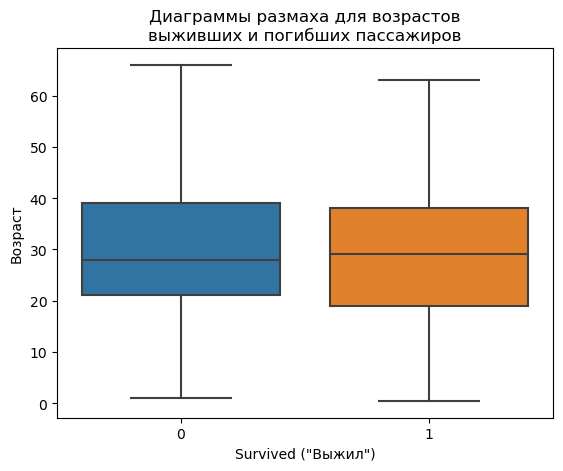

p-значение: 0.080
Не получилось отвергнуть нулевую гипотезу.


In [43]:
sns.boxplot(data=exploratory_set.query('Age < 70'), x='Survived', y='Age')

plt.xlabel('Survived ("Выжил")')
plt.ylabel('Возраст')
plt.title('Диаграммы размаха для возрастов\nвыживших и погибших пассажиров')

plt.show()


results = ttest_ind(exploratory_set.query('Survived == 0 and Age < 70').Age.dropna(),
                    exploratory_set.query('Survived == 1 and Age < 70').Age.dropna(),
                    equal_var=False,
                   )

print(f'p-значение: {results.pvalue:.3f}')

alpha = 0.05

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу.')
else:
    print('Не получилось отвергнуть нулевую гипотезу.')

Оценим к каком квантилю относится значение 70 (после удаления пропусков).

In [44]:
round(percentileofscore(exploratory_set.Age.dropna(), 70) / 100, 2)

0.99

**Можно подытожить, что у нас нет оснований утверждать, что средний возраст выживших и погибших отличается, или что фактор возраста имел решающее значение при спасении.**

Возраст непрерывная величина, но мы имеем дело с задачей классификации. Может быть целесообразным разбить всех пассажиров на на возрастные группы. В группы с более высокими номерами будем относить пассажиров, которые старше. При этом для дискретизации будем использовать функцию `pd.qcut`, чтобы в каждой группе оказалось одинаковое количество значений.

In [45]:
exploratory_set['AgeGroup'] = pd.qcut(exploratory_set.Age, q=5, labels=list(range(5)))

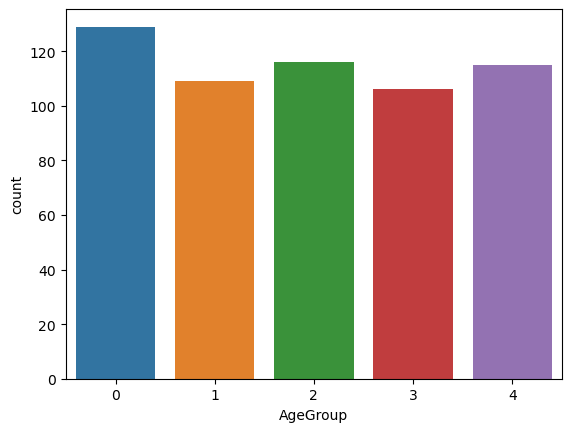

0    129
2    116
4    115
1    109
3    106
Name: AgeGroup, dtype: int64

In [46]:
sns.countplot(exploratory_set, x='AgeGroup')

plt.show()

display(exploratory_set.AgeGroup.value_counts())

#### SibSp

In [60]:
exploratory_set.SibSp.head()

788    1
347    1
629    0
734    0
106    0
Name: SibSp, dtype: int64

In [61]:
exploratory_set.SibSp.info()

<class 'pandas.core.series.Series'>
Int64Index: 712 entries, 788 to 261
Series name: SibSp
Non-Null Count  Dtype
--------------  -----
712 non-null    int64
dtypes: int64(1)
memory usage: 11.1 KB


In [62]:
exploratory_set.SibSp.describe()

count    712.000000
mean       0.546348
std        1.110283
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        8.000000
Name: SibSp, dtype: float64

In [63]:
exploratory_set.SibSp.value_counts(dropna=False)

0    477
1    171
2     25
4     16
3     13
8      5
5      5
Name: SibSp, dtype: int64

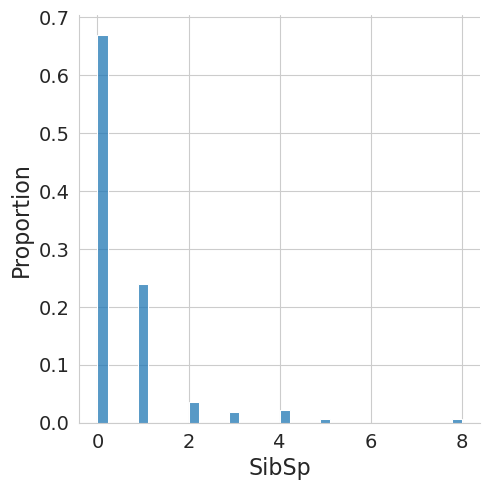

In [64]:
sns.displot(exploratory_set.SibSp, stat='proportion', kde=False)
# plt.savefig('../docs/images/sibsp_distribution.pdf', bbox_inches='tight')
plt.show()

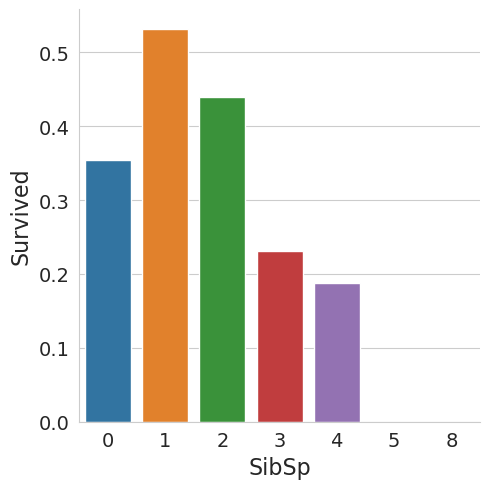

In [65]:
sns.catplot(data=exploratory_set, x='SibSp', y='Survived', kind='bar', errorbar=None)
# plt.savefig('../docs/images/sibsp_survival_rate.pdf', bbox_inches='tight')
plt.show()

#### Parch

In [66]:
exploratory_set.Parch.head()

788    2
347    0
629    0
734    0
106    0
Name: Parch, dtype: int64

In [67]:
exploratory_set.Parch.info()

<class 'pandas.core.series.Series'>
Int64Index: 712 entries, 788 to 261
Series name: Parch
Non-Null Count  Dtype
--------------  -----
712 non-null    int64
dtypes: int64(1)
memory usage: 11.1 KB


In [68]:
exploratory_set.Parch.describe()

count    712.000000
mean       0.373596
std        0.803144
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        6.000000
Name: Parch, dtype: float64

In [69]:
exploratory_set.Parch.value_counts(dropna=False)

0    543
1     99
2     58
5      4
4      4
3      3
6      1
Name: Parch, dtype: int64

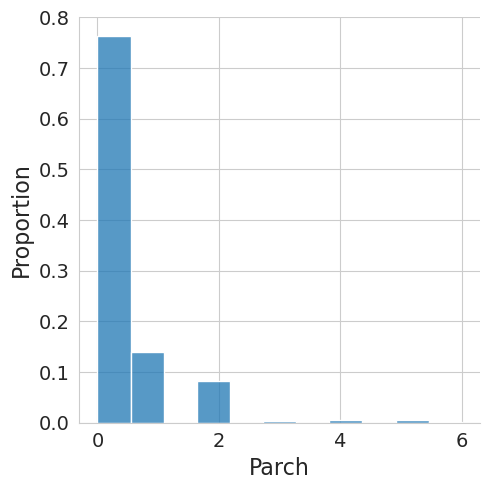

In [70]:
sns.displot(exploratory_set.Parch, stat='proportion', kde=False)
# plt.savefig('../docs/images/parch_distribution.pdf', bbox_inches='tight')
plt.show()

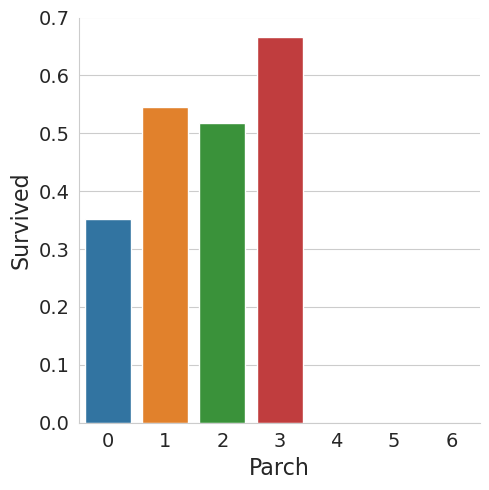

In [71]:
sns.catplot(data=exploratory_set, x='Parch', y='Survived', kind='bar', errorbar=None)
# plt.savefig('../docs/images/parch_survival_rate.pdf', bbox_inches='tight')
plt.show()

#### Fare

In [76]:
exploratory_set.Fare.head()

788    20.5750
347    16.1000
629     7.7333
734    13.0000
106     7.6500
Name: Fare, dtype: float64

In [77]:
exploratory_set.Fare.info()

<class 'pandas.core.series.Series'>
Int64Index: 712 entries, 788 to 261
Series name: Fare
Non-Null Count  Dtype  
--------------  -----  
712 non-null    float64
dtypes: float64(1)
memory usage: 11.1 KB


In [78]:
exploratory_set.Fare.describe()

count    712.000000
mean      31.282893
std       44.377233
min        0.000000
25%        7.895800
50%       14.456250
75%       31.275000
max      512.329200
Name: Fare, dtype: float64

In [79]:
exploratory_set.Fare.isna().sum()

0

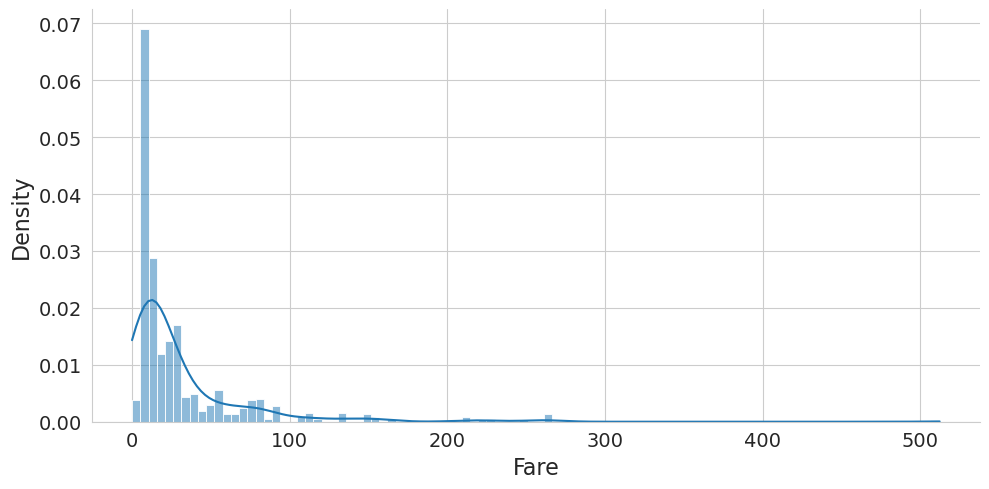

In [80]:
sns.displot(data=exploratory_set, x='Fare', stat='density', aspect=2, kde=True)
# plt.savefig('../docs/images/fare_distribution.pdf', bbox_inches='tight')
plt.show()

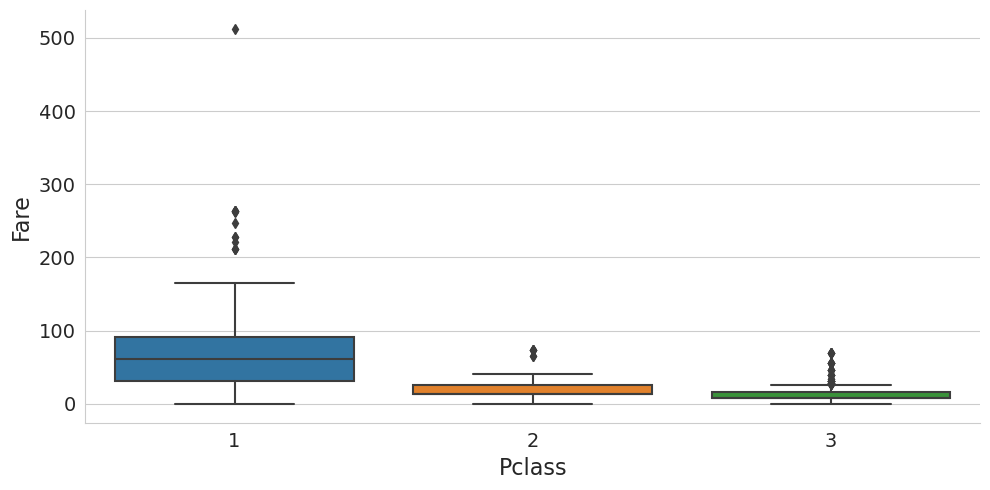

In [81]:
sns.catplot(data=exploratory_set, y='Fare', x='Pclass', aspect=2, kind='box')
# plt.savefig('../docs/images/fare_distribution_by_pclass.pdf', bbox_inches='tight')
plt.show()

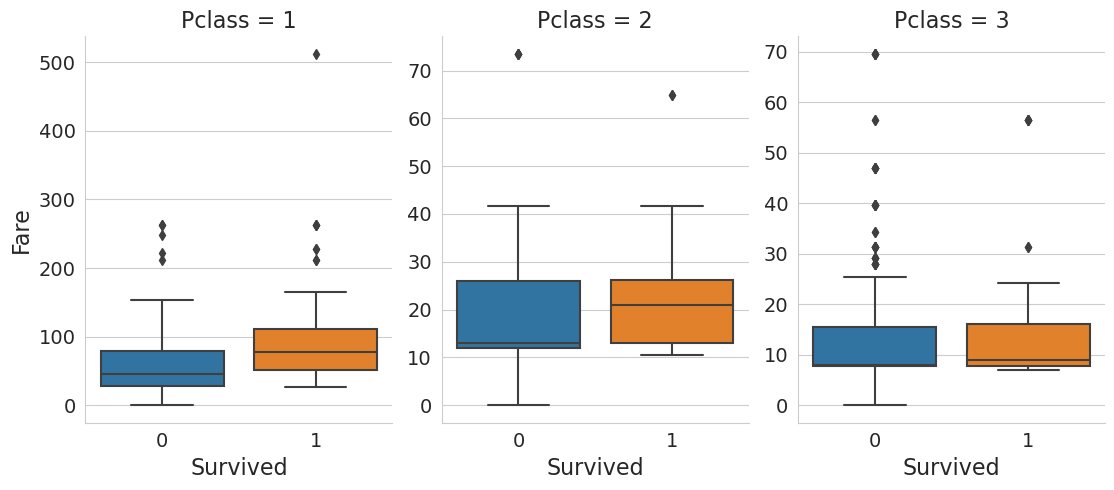

In [82]:
sns.catplot(data=exploratory_set, y='Fare', x='Survived', col='Pclass', sharey=False, kind='box', aspect=0.75)
# plt.savefig('../docs/images/fare_distribution_by_pclass_and_survived.pdf', bbox_inches='tight')
plt.show()

#### Cabin

In [83]:
exploratory_set.Cabin.head()

788    NaN
347    NaN
629    NaN
734    NaN
106    NaN
Name: Cabin, dtype: object

In [84]:
exploratory_set.Cabin.info()

<class 'pandas.core.series.Series'>
Int64Index: 712 entries, 788 to 261
Series name: Cabin
Non-Null Count  Dtype 
--------------  ----- 
164 non-null    object
dtypes: object(1)
memory usage: 27.3+ KB


In [85]:
exploratory_set.Cabin.describe()

count             164
unique            128
top       C23 C25 C27
freq                4
Name: Cabin, dtype: object

In [86]:
exploratory_set.Cabin.nunique()

128

In [87]:
exploratory_set.Cabin.value_counts(dropna=False)

NaN            548
C23 C25 C27      4
G6               3
B22              2
E24              2
              ... 
E38              1
B78              1
D46              1
C126             1
B94              1
Name: Cabin, Length: 129, dtype: int64

#### Embarked

In [88]:
exploratory_set.Embarked.head()

788    S
347    S
629    Q
734    S
106    S
Name: Embarked, dtype: object

In [89]:
exploratory_set.Embarked.info()

<class 'pandas.core.series.Series'>
Int64Index: 712 entries, 788 to 261
Series name: Embarked
Non-Null Count  Dtype 
--------------  ----- 
710 non-null    object
dtypes: object(1)
memory usage: 27.3+ KB


In [90]:
exploratory_set.Embarked.describe()

count     710
unique      3
top         S
freq      515
Name: Embarked, dtype: object

In [91]:
exploratory_set.Embarked.value_counts(dropna=False)

S      515
C      132
Q       63
NaN      2
Name: Embarked, dtype: int64

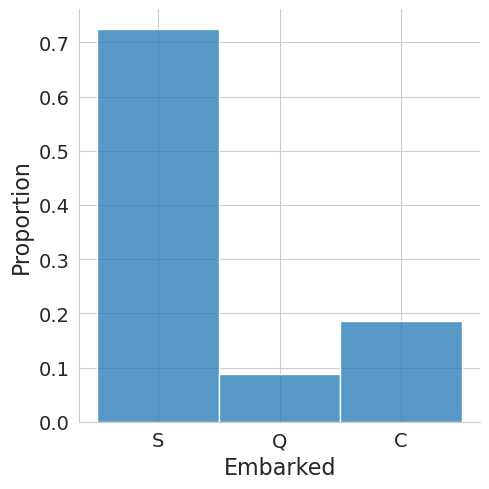

In [92]:
sns.displot(data=exploratory_set, x='Embarked', stat='proportion')
# plt.savefig('../docs/images/embarked_distribution.pdf', bbox_inches='tight')
plt.show()

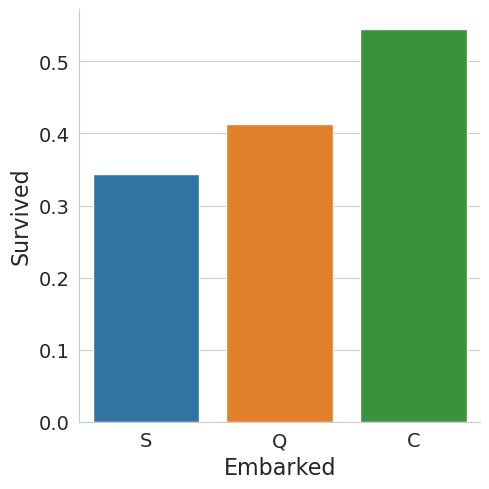

In [93]:
sns.catplot(data=exploratory_set, x='Embarked', y='Survived', kind='bar', errorbar=None)
# plt.savefig('../docs/images/embarked_survival_rate.pdf', bbox_inches='tight')
plt.show()

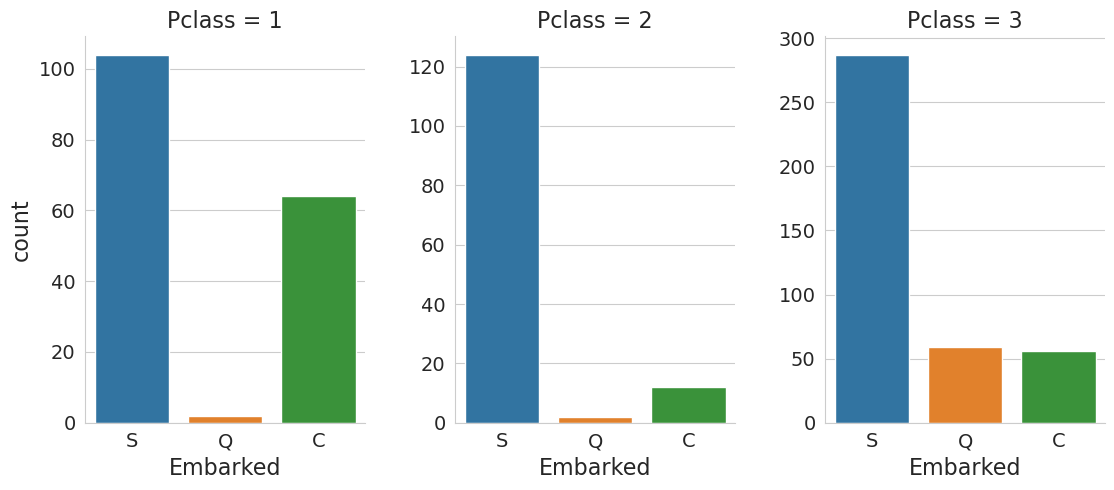

In [94]:
sns.catplot(data=exploratory_set, x='Embarked', col='Pclass', kind='count', sharey=False, aspect=0.75)
# plt.savefig('../docs/images/embarked_survival_rate_by_pclass.pdf', bbox_inches='tight')
plt.show()

### Correlation

In [95]:
exploratory_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 712 entries, 788 to 261
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   PassengerId  712 non-null    int64   
 1   Survived     712 non-null    int64   
 2   Pclass       712 non-null    category
 3   Name         712 non-null    object  
 4   Sex          712 non-null    object  
 5   Age          578 non-null    float64 
 6   SibSp        712 non-null    int64   
 7   Parch        712 non-null    int64   
 8   Ticket       712 non-null    object  
 9   Fare         712 non-null    float64 
 10  Cabin        164 non-null    object  
 11  Embarked     710 non-null    object  
 12  Title        712 non-null    object  
dtypes: category(1), float64(2), int64(4), object(6)
memory usage: 89.3+ KB


In [96]:
exploratory_set.Pclass = exploratory_set.Pclass.astype(np.int64)
exploratory_set.corr()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
PassengerId,1.000000,-0.040851,0.007666,0.013094,-0.060270,0.008112,-0.018438
Survived,-0.040851,1.000000,-0.314577,-0.075542,-0.045019,0.059276,0.248255
Pclass,0.007666,-0.314577,1.000000,-0.410414,0.088154,0.023130,-0.581269
Age,0.013094,-0.075542,-0.410414,1.000000,-0.326746,-0.184323,0.132593
SibSp,-0.060270,-0.045019,0.088154,-0.326746,1.000000,0.417455,0.187942
Parch,0.008112,0.059276,0.023130,-0.184323,0.417455,1.000000,0.258895
Fare,-0.018438,0.248255,-0.581269,0.132593,0.187942,0.258895,1.000000


In [97]:
def plot_diag_cor_matrix(data, ax, annot=True, vmin=-1, vmax=1):
    corr = data.corr()
    
    mask = np.triu(np.ones_like(corr, dtype=bool))
    
    cmap = sns.color_palette("coolwarm", as_cmap=True)
    
    sns.heatmap(corr, 
                mask=mask, 
                cmap=cmap, 
                annot=annot,
                vmax=vmax,
                vmin=vmin,
                center=0, 
                square=True, 
                linewidths=3,
                cbar_kws={"shrink": .5},
                annot_kws={"fontsize": 14}
               )
    
    ax.set_title('Correlation coefficient')
    
    return ax

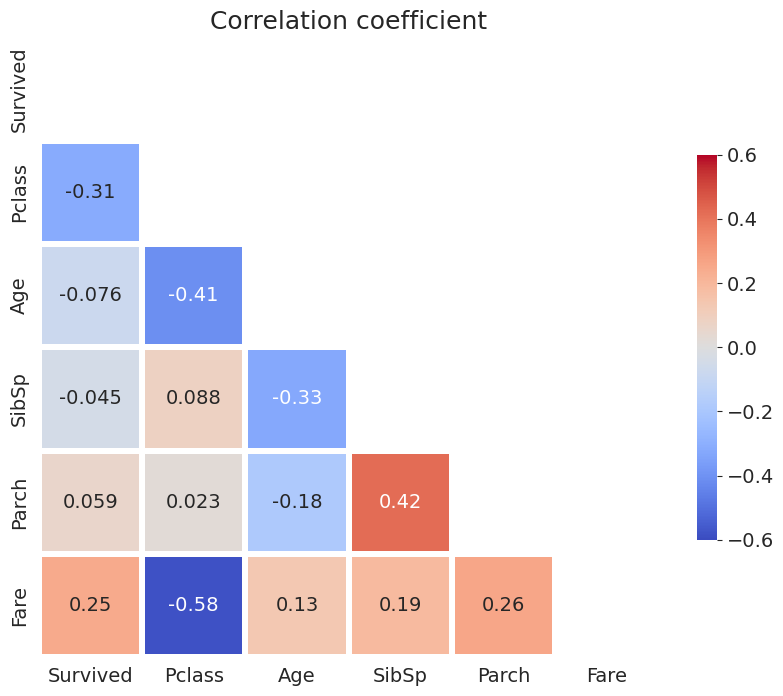

In [98]:
f, ax = plt.subplots(figsize=(10, 10))
ax = plot_diag_cor_matrix(exploratory_set.drop(columns='PassengerId'), ax, vmin=-0.6, vmax=0.6)
# plt.savefig('../docs/images/diag_cor_matrix_0.pdf', bbox_inches='tight')
plt.show()

## Data Preparation

### Copy a clean training set

In [99]:
X_train = train_set.drop(columns='Survived')
y_train = train_set.Survived.copy()

### Data Cleaning

In [100]:
pd.concat([X_train, y_train], axis=1).head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived
788,789,3,"Dean, Master. Bertram Vere",male,1.0,1,2,C.A. 2315,20.5750,NaN,S,1
347,348,3,"Davison, Mrs. Thomas Henry (Mary E Finck)",female,NaN,1,0,386525,16.1000,NaN,S,1
629,630,3,"O'Connell, Mr. Patrick D",male,NaN,0,0,334912,7.7333,NaN,Q,0
734,735,2,"Troupiansky, Mr. Moses Aaron",male,23.0,0,0,233639,13.0000,NaN,S,0
106,107,3,"Salkjelsvik, Miss. Anna Kristine",female,21.0,0,0,343120,7.6500,NaN,S,1


In [101]:
pd.concat([X_train, y_train], axis=1).info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 712 entries, 788 to 261
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  712 non-null    int64  
 1   Pclass       712 non-null    int64  
 2   Name         712 non-null    object 
 3   Sex          712 non-null    object 
 4   Age          578 non-null    float64
 5   SibSp        712 non-null    int64  
 6   Parch        712 non-null    int64  
 7   Ticket       712 non-null    object 
 8   Fare         712 non-null    float64
 9   Cabin        164 non-null    object 
 10  Embarked     710 non-null    object 
 11  Survived     712 non-null    int64  
dtypes: float64(2), int64(5), object(5)
memory usage: 88.5+ KB


In [102]:
pd.concat([X_train, y_train], axis=1).isna().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age            134
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          548
Embarked         2
Survived         0
dtype: int64

In [103]:
imputer = DataFrameMapper([
    (['Age'], SimpleImputer(strategy='median')),
    (['Embarked'], SimpleImputer(strategy='most_frequent')),
    (['Cabin'], MissingIndicator()),
], default=None, df_out=True)

In [104]:
imputer.fit_transform(X_train).head()

,Age,Embarked,Cabin,PassengerId,Pclass,Name,Sex,SibSp,Parch,Ticket,Fare
788,1.0,S,True,789,3,"Dean, Master. Bertram Vere",male,1,2,C.A. 2315,20.575
347,28.0,S,True,348,3,"Davison, Mrs. Thomas Henry (Mary E Finck)",female,1,0,386525,16.1
629,28.0,Q,True,630,3,"O'Connell, Mr. Patrick D",male,0,0,334912,7.7333
734,23.0,S,True,735,2,"Troupiansky, Mr. Moses Aaron",male,0,0,233639,13.0
106,21.0,S,True,107,3,"Salkjelsvik, Miss. Anna Kristine",female,0,0,343120,7.65


In [105]:
imputer.fit_transform(X_train).isna().sum()

Age            0
Embarked       0
Cabin          0
PassengerId    0
Pclass         0
Name           0
Sex            0
SibSp          0
Parch          0
Ticket         0
Fare           0
dtype: int64

### Feature Selection

In [106]:
selector = DataFrameMapper([], drop_cols=['PassengerId', 'Ticket'], default=None, df_out=True)

In [107]:
data_prep = Pipeline([
    ('imputer', imputer),
    ('selector', selector),
])

In [108]:
data_prep.fit_transform(X_train).head()

,Age,Embarked,Cabin,Pclass,Name,Sex,SibSp,Parch,Fare
788,1.0,S,True,3,"Dean, Master. Bertram Vere",male,1,2,20.575
347,28.0,S,True,3,"Davison, Mrs. Thomas Henry (Mary E Finck)",female,1,0,16.1
629,28.0,Q,True,3,"O'Connell, Mr. Patrick D",male,0,0,7.7333
734,23.0,S,True,2,"Troupiansky, Mr. Moses Aaron",male,0,0,13.0
106,21.0,S,True,3,"Salkjelsvik, Miss. Anna Kristine",female,0,0,7.65


### Feature engineering

In [109]:
class TitleAdder(BaseEstimator, TransformerMixin):
    
    def __init__(self, drop_name=True, group=True):
        self.drop_name = drop_name
        self.group =group
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X['Title'] = X.Name.str.extract(pat=r'\b,\s(.+)\.\s[\b(]?', expand=True)
        X.Title = X.Title.str.lower()
        
        if self.group:
            aristocratic_titles = ['rev', 'lady', 'dr', 
                                   'jonkheer', 'major', 'col', 
                                   'ms', 'the countess', 'don', 
                                   'mme', 'sir', 'capt', 'mlle']
            
            X.Title[X.Title.isin(aristocratic_titles)] = 'aristocratic'
        
        if self.drop_name:
            return X.drop(columns='Name')
        
        return X

In [110]:
data_prep = Pipeline([
    ('imputer', imputer),
    ('selector', selector),
    ('title_adder', TitleAdder())
])

In [111]:
data_prep.fit_transform(X_train).Title.unique()

array(['master', 'mrs', 'mr', 'miss', 'aristocratic'], dtype=object)

In [112]:
data_prep.fit_transform(X_train).head()

,Age,Embarked,Cabin,Pclass,Sex,SibSp,Parch,Fare,Title
788,1.0,S,True,3,male,1,2,20.575,master
347,28.0,S,True,3,female,1,0,16.1,mrs
629,28.0,Q,True,3,male,0,0,7.7333,mr
734,23.0,S,True,2,male,0,0,13.0,mr
106,21.0,S,True,3,female,0,0,7.65,miss


In [113]:
class FamilyAdder(BaseEstimator, TransformerMixin):
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X['Family'] = X.SibSp + X.Parch
        
        return X

In [114]:
data_prep = Pipeline([
    ('imputer', imputer),
    ('selector', selector),
    ('title_adder', TitleAdder()),
    ('family_adder', FamilyAdder())
])

In [115]:
data_prep.fit_transform(X_train).head()

,Age,Embarked,Cabin,Pclass,Sex,SibSp,Parch,Fare,Title,Family
788,1.0,S,True,3,male,1,2,20.575,master,3
347,28.0,S,True,3,female,1,0,16.1,mrs,1
629,28.0,Q,True,3,male,0,0,7.7333,mr,0
734,23.0,S,True,2,male,0,0,13.0,mr,0
106,21.0,S,True,3,female,0,0,7.65,miss,0


In [116]:
class isFamilyAdder(BaseEstimator, TransformerMixin):
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X['isFamily'] = X.Family.where(X.Family < 1, 1)
        
        return X

In [117]:
data_prep = Pipeline([
    ('imputer', imputer),
    ('selector', selector),
    ('title_adder', TitleAdder()),
    ('family_adder', FamilyAdder()),
    ('isfamily_adder', isFamilyAdder())
])

In [118]:
data_prep.fit_transform(X_train).head()

,Age,Embarked,Cabin,Pclass,Sex,SibSp,Parch,Fare,Title,Family,isFamily
788,1.0,S,True,3,male,1,2,20.575,master,3,1
347,28.0,S,True,3,female,1,0,16.1,mrs,1,1
629,28.0,Q,True,3,male,0,0,7.7333,mr,0,0
734,23.0,S,True,2,male,0,0,13.0,mr,0,0
106,21.0,S,True,3,female,0,0,7.65,miss,0,0


### Discretization of continuous variables

In [119]:
discretizer = DataFrameMapper([
    (['Age'], None),
    (['Age'], KBinsDiscretizer(n_bins=5, encode='ordinal'), {'suffix': '_discr'}),
    (['Fare'], None),
    (['Fare'], KBinsDiscretizer(n_bins=5, encode='ordinal'), {'suffix': '_discr'}),
], default=None, df_out=True)

In [120]:
data_prep = Pipeline([
    ('imputer', imputer),
    ('selector', selector),
    ('title_adder', TitleAdder()),
    ('family_adder', FamilyAdder()),
    ('discretizer', discretizer)
])

In [121]:
data_prep.fit_transform(X_train).head()

,Age,Age_discr,Fare,Fare_discr,Embarked,Cabin,Pclass,Sex,SibSp,Parch,Title,Family
788,1.0,0.0,20.575,2.0,S,True,3,male,1,2,master,3
347,28.0,2.0,16.1,2.0,S,True,3,female,1,0,mrs,1
629,28.0,2.0,7.7333,0.0,Q,True,3,male,0,0,mr,0
734,23.0,1.0,13.0,2.0,S,True,2,male,0,0,mr,0
106,21.0,1.0,7.65,0.0,S,True,3,female,0,0,miss,0


In [122]:
data_prep.fit_transform(X_train).info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 712 entries, 788 to 261
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Age         712 non-null    object 
 1   Age_discr   712 non-null    float64
 2   Fare        712 non-null    object 
 3   Fare_discr  712 non-null    float64
 4   Embarked    712 non-null    object 
 5   Cabin       712 non-null    object 
 6   Pclass      712 non-null    object 
 7   Sex         712 non-null    object 
 8   SibSp       712 non-null    object 
 9   Parch       712 non-null    object 
 10  Title       712 non-null    object 
 11  Family      712 non-null    object 
dtypes: float64(2), object(10)
memory usage: 88.5+ KB


### Handling Categorical Attributes

In [123]:
to_float_converter = FunctionTransformer(lambda x: x.astype('float'))

In [124]:
encoder = DataFrameMapper([
    (['Sex'], OrdinalEncoder()),
    (['Embarked'], OneHotEncoder(sparse=False)),
    (['Title'], OneHotEncoder(sparse=False)),
], default=None, df_out=True)

In [125]:
data_prep = Pipeline([
    ('imputer', imputer),
    ('selector', selector),
    ('title_adder', TitleAdder()),
    ('family_adder', FamilyAdder()),
    ('isfamily_adder', isFamilyAdder()),
    ('discretizer', discretizer),
    ('encoder', encoder),
    ('to_float_converter', FunctionTransformer(lambda x: x.astype('float')))
])

In [126]:
X_train_prepared = data_prep.fit_transform(X_train)

/home/aleksei/anaconda3/envs/DataScience/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/home/aleksei/anaconda3/envs/DataScience/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [127]:
X_train_prepared.head()

,Sex,Embarked_x0_C,Embarked_x0_Q,Embarked_x0_S,Title_x0_aristocratic,Title_x0_master,Title_x0_miss,Title_x0_mr,Title_x0_mrs,Age,Age_discr,Fare,Fare_discr,Cabin,Pclass,SibSp,Parch,Family,isFamily
788,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,20.5750,2.0,1.0,3.0,1.0,2.0,3.0,1.0
347,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,28.0,2.0,16.1000,2.0,1.0,3.0,1.0,0.0,1.0,1.0
629,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,28.0,2.0,7.7333,0.0,1.0,3.0,0.0,0.0,0.0,0.0
734,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,23.0,1.0,13.0000,2.0,1.0,2.0,0.0,0.0,0.0,0.0
106,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,21.0,1.0,7.6500,0.0,1.0,3.0,0.0,0.0,0.0,0.0


In [128]:
X_train_prepared.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 712 entries, 788 to 261
Data columns (total 19 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Sex                    712 non-null    float64
 1   Embarked_x0_C          712 non-null    float64
 2   Embarked_x0_Q          712 non-null    float64
 3   Embarked_x0_S          712 non-null    float64
 4   Title_x0_aristocratic  712 non-null    float64
 5   Title_x0_master        712 non-null    float64
 6   Title_x0_miss          712 non-null    float64
 7   Title_x0_mr            712 non-null    float64
 8   Title_x0_mrs           712 non-null    float64
 9   Age                    712 non-null    float64
 10  Age_discr              712 non-null    float64
 11  Fare                   712 non-null    float64
 12  Fare_discr             712 non-null    float64
 13  Cabin                  712 non-null    float64
 14  Pclass                 712 non-null    float64
 15  SibS

In [129]:
X_train_prepared.shape

(712, 19)

### Correlation

In [130]:
X_train_prepared.corr().min().min()

-0.7767851861770988

In [131]:
corrmatrix = X_train_prepared.corr()
corrmatrix[corrmatrix==1]=0
corrmatrix.max().max()

0.8926827618304913

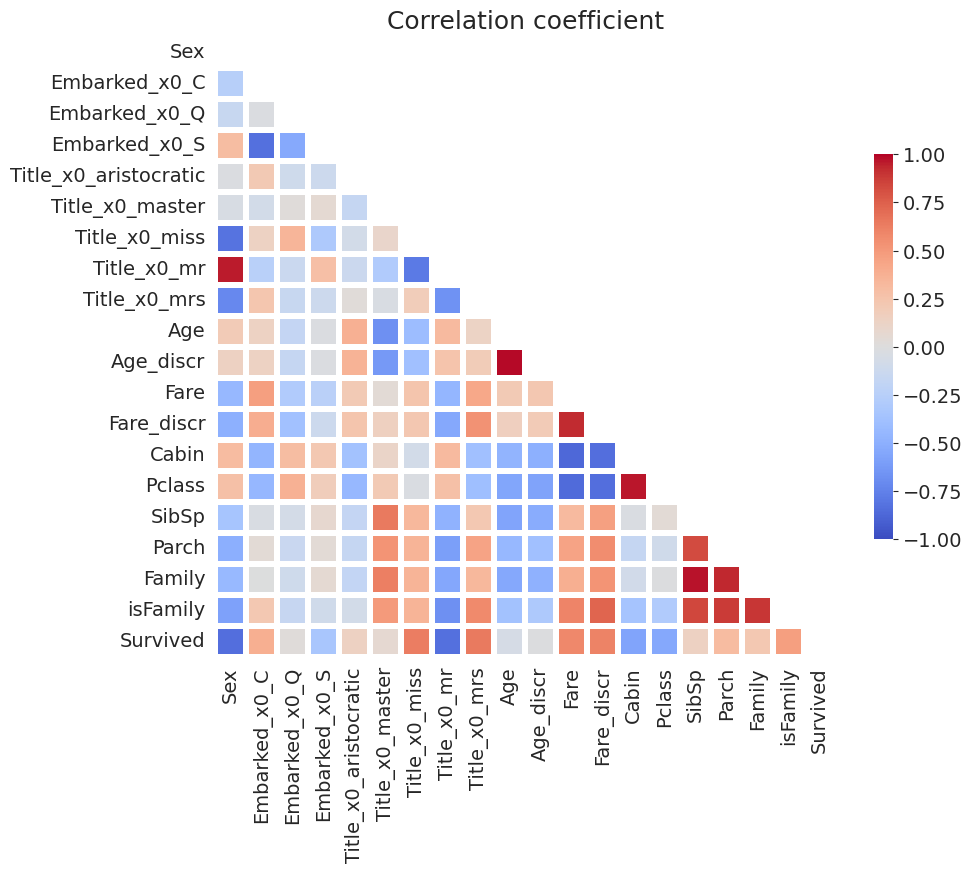

In [132]:
f, ax = plt.subplots(figsize=(10, 10))
ax = plot_diag_cor_matrix(pd.concat([X_train_prepared, y_train], axis=1).corr(), ax, annot=False)

plt.show()

In [133]:
survived_corr = pd.concat([X_train_prepared, y_train], axis=1).corr().Survived.drop(index='Survived')
survived_corr = survived_corr.reset_index().rename(columns = {'index': 'feature_name', 'Survived': 'correlation'})
survived_corr = survived_corr.sort_values(by='correlation', ascending=False)

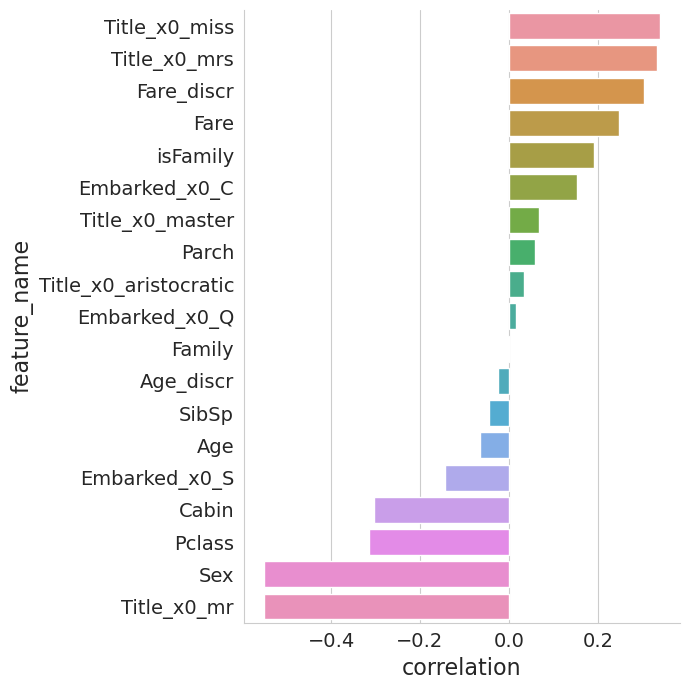

In [134]:
sns.catplot(data=survived_corr, 
            x='correlation', 
            y='feature_name', 
            kind='bar', 
            errorbar=None, 
            height=7
           )
plt.show()

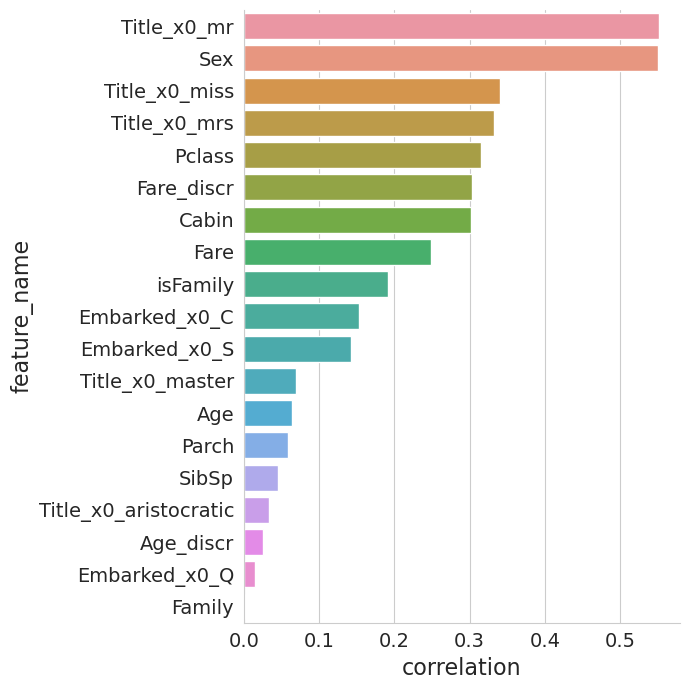

In [135]:
survived_corr_abs = survived_corr.copy()
survived_corr_abs.correlation = survived_corr.correlation.abs()
survived_corr_abs = survived_corr_abs.sort_values(by='correlation', ascending=False)

sns.catplot(data=survived_corr_abs, 
            x='correlation', 
            y='feature_name', 
            kind='bar', 
            errorbar=None, 
            height=7
           )
plt.show()

### Mutual Info

In [136]:
mi_score = mutual_info_classif(X=X_train_prepared, y=y_train)
mi_score = pd.DataFrame(mi_score, index=X_train_prepared.columns, columns=['MI_score'])
mi_score = mi_score.sort_values(by='MI_score', ascending=False).reset_index()
mi_score = mi_score.rename(columns = {'index': 'feature_name'})

In [137]:
mi_score

,feature_name,MI_score
0,Sex,0.160724
1,Title_x0_mr,0.141986
2,Fare,0.138671
3,Cabin,0.066070
4,Title_x0_miss,0.061365
5,SibSp,0.055778
6,Fare_discr,0.050612
7,isFamily,0.041788
8,Title_x0_mrs,0.038698
9,Pclass,0.038430


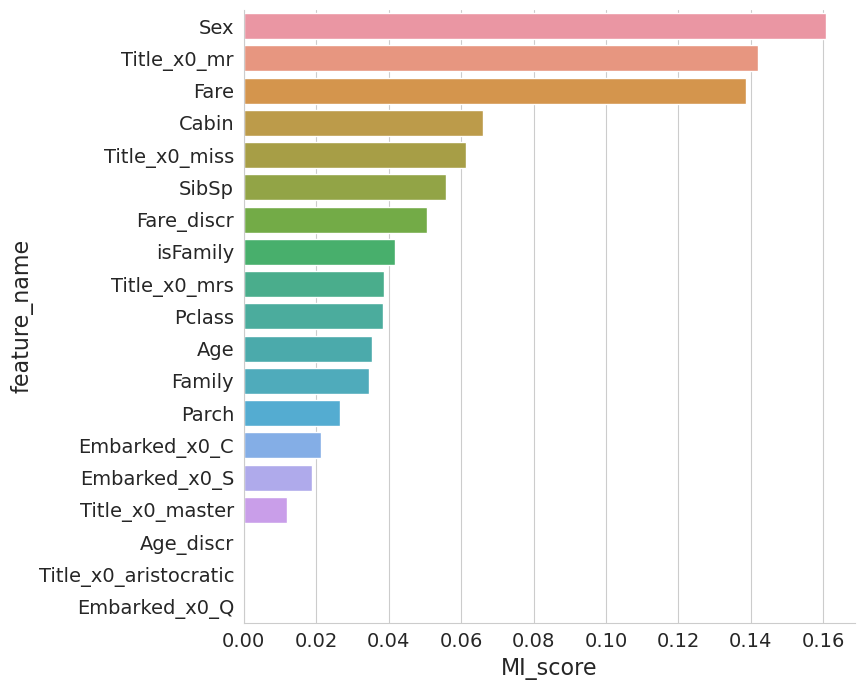

In [138]:
sns.catplot(data=mi_score, x='MI_score', y='feature_name', kind='bar', errorbar=None, height=7, aspect=1.25)
plt.show()

### 

https://ru.wikipedia.org/wiki/%D0%A2%D0%B8%D1%82%D0%B0%D0%BD%D0%B8%D0%BA

https://www.tensorflow.org/datasets/catalog/titanic

https://habr.com/ru/company/mlclass/blog/270973/

https://towardsdatascience.com/machine-learning-with-the-titanic-dataset-7f6909e58280

https://ru.wikipedia.org/wiki/%D0%9F%D0%B0%D1%81%D1%81%D0%B0%D0%B6%D0%B8%D1%80%D1%8B_%C2%AB%D0%A2%D0%B8%D1%82%D0%B0%D0%BD%D0%B8%D0%BA%D0%B0%C2%BB

https://www.openml.org/search?type=data&sort=runs&id=40945&status=active